# House_Performance

This is an assignment for my thinkful data science course - "House_Performance"
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/House_Performance.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/House_Performance.ipynb) - with all the code exposed in an interactive notebook

**NOTE** This exercise adds an addendum to a previous project.  The addendum focuses on performance evaluation, and the last few model runs, at the bottom of the workbook, cover those topics.  

## House prices dataset

I'm demonstrating a linear regression modeling on a house prices dataset originally from Kaggle. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The target variable will be the "SalePrice" (the property's sale price in dollars). Since it's a continuous variable, we're dealing with a regression task.


In [1]:
#imports & connection
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
#db connection
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
#data load
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



In [4]:
#reset index, head of raw data
houses_df.set_index("id")
houses_df.head()


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [5]:
houses_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
houses_df.describe(include="O")

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


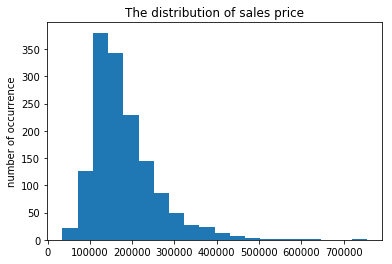

In [7]:
# target variable distribution
plt.hist(houses_df.saleprice, bins=20)
plt.title("The distribution of sales price")
plt.ylabel("number of occurrence")
plt.show()

We observe that sales price is not quite normally distributed. Instead, it's highly skewed. **Skewness** is a measure of how asymmetric our data is with respect to the normal distribution. As we see in the graph, the sales price variable is not symmetric but skewed to the right. The majority of the observations have low prices and few of the observations have high prices. This makes the distribution of the charges clustered toward the left.

In [8]:
#look for missing values and drop those columns
#there are plenty of powerful variables without missing values, so I will not spend energy investigating 
#variables with missing values. 

def remove_null_cols(df):
    n = len(df)
    cols = df.columns
    null_cols = [(len(df[df[col].isnull()]) == 0) for col in df]
    return df.iloc[:, null_cols]
    
houses_df = remove_null_cols(houses_df)

In [9]:
#get all the continuous and categorical columns
#thus far I'm just exploring the categorical columns.  Eventually I would like to explore the continuous.

from itertools import compress

cont_cols = list(compress(houses_df.columns, houses_df.dtypes == int))
cat_cols = list(compress(houses_df.columns, houses_df.dtypes == object))

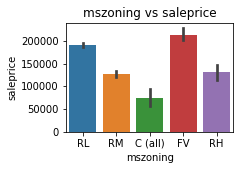

t-test between groups RL and RM is significant:  p = 5.31147433276907e-29:
t-test between groups RL and C (all) is significant:  p = 5.781371468431197e-06:
t-test between groups RL and FV is significant:  p = 0.023411437975482768:
t-test between groups RL and RH is significant:  p = 0.0033561549774499266:
t-test between groups RM and C (all) is significant:  p = 0.000997822737851211:
t-test between groups RM and FV is significant:  p = 5.290552561341391e-29:
t-test between groups C (all) and FV is significant:  p = 7.703220225844747e-12:
t-test between groups C (all) and RH is significant:  p = 0.00047440031531897984:
t-test between groups FV and RH is significant:  p = 6.90819126572009e-08:


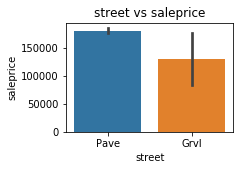

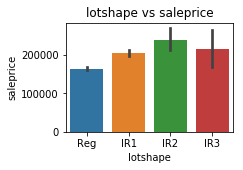

t-test between groups Reg and IR1 is significant:  p = 9.171976277508485e-22:
t-test between groups Reg and IR2 is significant:  p = 6.35746592217739e-11:
t-test between groups Reg and IR3 is significant:  p = 0.02107467185053599:
t-test between groups IR1 and IR2 is significant:  p = 0.017484779279881728:


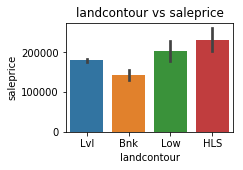

t-test between groups Lvl and Bnk is significant:  p = 0.00021137060129819673:
t-test between groups Lvl and HLS is significant:  p = 7.835920892109534e-06:
t-test between groups Bnk and Low is significant:  p = 1.7008132686172627e-05:
t-test between groups Bnk and HLS is significant:  p = 1.9031917524183677e-08:


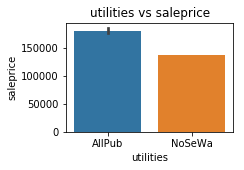

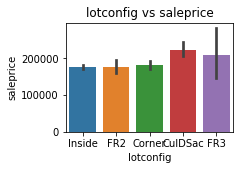

t-test between groups Inside and CulDSac is significant:  p = 2.7848227036514676e-08:
t-test between groups FR2 and CulDSac is significant:  p = 0.0027476083240980985:
t-test between groups Corner and CulDSac is significant:  p = 6.344276933784969e-05:


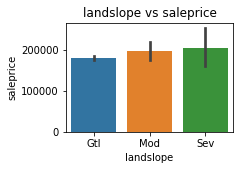

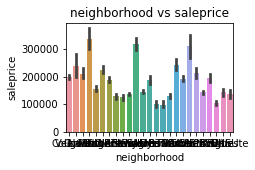

t-test between groups CollgCr and Veenker is significant:  p = 0.01471121255220082:
t-test between groups CollgCr and NoRidge is significant:  p = 1.70585467008937e-21:
t-test between groups CollgCr and Mitchel is significant:  p = 3.7808487824887005e-07:
t-test between groups CollgCr and Somerst is significant:  p = 0.00017719270534679517:
t-test between groups CollgCr and OldTown is significant:  p = 1.1938036953251736e-22:
t-test between groups CollgCr and BrkSide is significant:  p = 1.1703954268460629e-18:
t-test between groups CollgCr and Sawyer is significant:  p = 5.077015265496151e-19:
t-test between groups CollgCr and NridgHt is significant:  p = 3.413277523206259e-26:
t-test between groups CollgCr and NAmes is significant:  p = 4.407905553642542e-28:
t-test between groups CollgCr and IDOTRR is significant:  p = 5.349070063364893e-22:
t-test between groups CollgCr and MeadowV is significant:  p = 4.630896998224385e-13:
t-test between groups CollgCr and Edwards is significant:

t-test between groups BrkSide and Sawyer is significant:  p = 0.03239144994484774:
t-test between groups BrkSide and NridgHt is significant:  p = 1.9193610070727513e-28:
t-test between groups BrkSide and NAmes is significant:  p = 5.087420652083773e-05:
t-test between groups BrkSide and SawyerW is significant:  p = 3.7014777835926983e-10:
t-test between groups BrkSide and IDOTRR is significant:  p = 0.0025084436390216056:
t-test between groups BrkSide and MeadowV is significant:  p = 0.012814930255200798:
t-test between groups BrkSide and Timber is significant:  p = 1.8409340250765704e-18:
t-test between groups BrkSide and Gilbert is significant:  p = 6.355220922419745e-19:
t-test between groups BrkSide and StoneBr is significant:  p = 7.478200828637989e-18:
t-test between groups BrkSide and ClearCr is significant:  p = 2.2735740305491953e-13:
t-test between groups BrkSide and Blmngtn is significant:  p = 5.343585955617714e-09:
t-test between groups Sawyer and NridgHt is significant:  

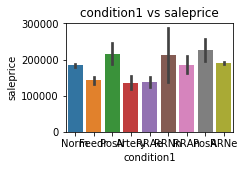

t-test between groups Norm and Feedr is significant:  p = 4.3444577659362514e-06:
t-test between groups Norm and Artery is significant:  p = 3.397647338816598e-05:
t-test between groups Feedr and PosN is significant:  p = 2.8218732203779762e-08:
t-test between groups Feedr and RRNn is significant:  p = 0.001410937039704686:
t-test between groups Feedr and RRAn is significant:  p = 0.00024391065053256845:
t-test between groups Feedr and PosA is significant:  p = 1.177174708062123e-06:
t-test between groups PosN and Artery is significant:  p = 3.093055757763581e-05:
t-test between groups PosN and RRAe is significant:  p = 0.0008503447479558294:
t-test between groups Artery and RRNn is significant:  p = 0.020510542921083823:
t-test between groups Artery and RRAn is significant:  p = 0.00312560184203069:
t-test between groups Artery and PosA is significant:  p = 0.0005390325315537501:
t-test between groups RRAe and RRNn is significant:  p = 0.023766739905403376:
t-test between groups RRAe 

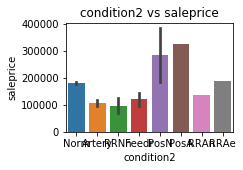

t-test between groups Feedr and PosN is significant:  p = 0.0220840758705002:


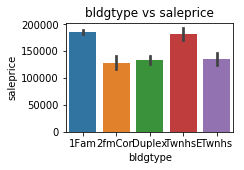

t-test between groups 1Fam and 2fmCon is significant:  p = 0.00012309127638279022:
t-test between groups 1Fam and Duplex is significant:  p = 6.046271686674719e-06:
t-test between groups 1Fam and Twnhs is significant:  p = 8.69606941410259e-05:
t-test between groups 2fmCon and TwnhsE is significant:  p = 6.190767497269936e-06:
t-test between groups Duplex and TwnhsE is significant:  p = 1.4731286100745727e-07:
t-test between groups TwnhsE and Twnhs is significant:  p = 8.90624373255204e-06:


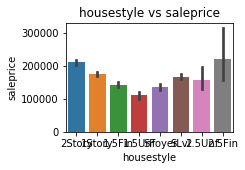

t-test between groups 2Story and 1Story is significant:  p = 5.080795678268962e-12:
t-test between groups 2Story and 1.5Fin is significant:  p = 5.254202320262874e-18:
t-test between groups 2Story and 1.5Unf is significant:  p = 2.354869492773719e-05:
t-test between groups 2Story and SFoyer is significant:  p = 3.0899091284796314e-07:
t-test between groups 2Story and SLvl is significant:  p = 9.145925964632968e-05:
t-test between groups 2Story and 2.5Unf is significant:  p = 0.04751995148771409:
t-test between groups 1Story and 1.5Fin is significant:  p = 5.826360271701624e-07:
t-test between groups 1Story and 1.5Unf is significant:  p = 0.0014679975978038765:
t-test between groups 1Story and SFoyer is significant:  p = 0.0013593845492056202:
t-test between groups 1.5Fin and 1.5Unf is significant:  p = 0.02546470487741969:
t-test between groups 1.5Fin and SLvl is significant:  p = 0.001671726205049616:
t-test between groups 1.5Fin and 2.5Fin is significant:  p = 0.000393521621205551:
t

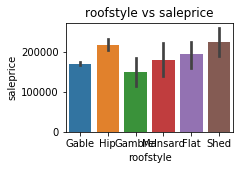

t-test between groups Gable and Hip is significant:  p = 8.248564976411261e-20:
t-test between groups Hip and Gambrel is significant:  p = 0.039901945561788575:


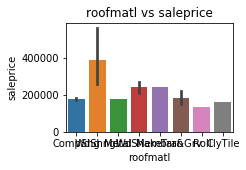

t-test between groups CompShg and WdShngl is significant:  p = 8.011917378563762e-11:
t-test between groups WdShngl and Tar&Grv is significant:  p = 0.007566686120613379:


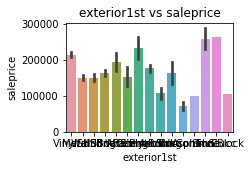

t-test between groups VinylSd and MetalSd is significant:  p = 2.278402343992355e-25:
t-test between groups VinylSd and Wd Sdng is significant:  p = 7.329159814225127e-22:
t-test between groups VinylSd and HdBoard is significant:  p = 8.217122574015741e-16:
t-test between groups VinylSd and WdShing is significant:  p = 0.0001046674885485102:
t-test between groups VinylSd and Plywood is significant:  p = 3.4197057592624217e-06:
t-test between groups VinylSd and AsbShng is significant:  p = 7.537509047619964e-09:
t-test between groups VinylSd and Stucco is significant:  p = 0.002265581430503154:
t-test between groups VinylSd and BrkComm is significant:  p = 0.012713780341682933:
t-test between groups MetalSd and HdBoard is significant:  p = 0.018746068520829433:
t-test between groups MetalSd and BrkFace is significant:  p = 3.5763441336082635e-06:
t-test between groups MetalSd and CemntBd is significant:  p = 2.723011331462887e-13:
t-test between groups MetalSd and Plywood is significant

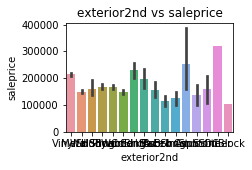

t-test between groups VinylSd and MetalSd is significant:  p = 6.772097948345956e-25:
t-test between groups VinylSd and Wd Shng is significant:  p = 0.00011610493355953484:
t-test between groups VinylSd and HdBoard is significant:  p = 8.561304357355222e-13:
t-test between groups VinylSd and Plywood is significant:  p = 1.315462717569023e-10:
t-test between groups VinylSd and Wd Sdng is significant:  p = 1.0130154502569358e-23:
t-test between groups VinylSd and Stucco is significant:  p = 0.0003256684047821821:
t-test between groups VinylSd and AsbShng is significant:  p = 5.1240562815848603e-08:
t-test between groups VinylSd and Brk Cmn is significant:  p = 0.0042909988874625824:
t-test between groups MetalSd and HdBoard is significant:  p = 0.0037748220027940026:
t-test between groups MetalSd and Plywood is significant:  p = 0.0012503523575587033:
t-test between groups MetalSd and CmentBd is significant:  p = 6.658569044400864e-13:
t-test between groups MetalSd and BrkFace is signifi

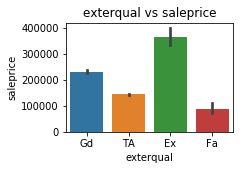

t-test between groups Gd and TA is significant:  p = 3.0929104042668016e-142:
t-test between groups Gd and Ex is significant:  p = 3.7436261321263935e-30:
t-test between groups Gd and Fa is significant:  p = 2.711991042601849e-13:
t-test between groups TA and Ex is significant:  p = 1.834062772729737e-151:
t-test between groups TA and Fa is significant:  p = 9.701587725575749e-07:
t-test between groups Ex and Fa is significant:  p = 1.2690334856482733e-12:


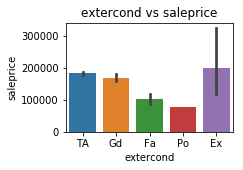

t-test between groups TA and Gd is significant:  p = 0.02862658485705652:
t-test between groups TA and Fa is significant:  p = 8.65069926536167e-08:
t-test between groups Gd and Fa is significant:  p = 5.559501280977647e-06:
t-test between groups Fa and Ex is significant:  p = 0.002115262754911211:


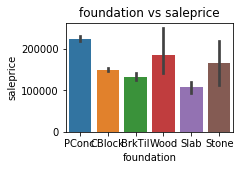

t-test between groups PConc and CBlock is significant:  p = 4.295762040126887e-72:
t-test between groups PConc and BrkTil is significant:  p = 2.540186641764687e-32:
t-test between groups PConc and Slab is significant:  p = 7.180996389200298e-11:
t-test between groups CBlock and BrkTil is significant:  p = 0.00012668736227958123:
t-test between groups CBlock and Slab is significant:  p = 2.3109923538967075e-05:
t-test between groups BrkTil and Slab is significant:  p = 0.03181522412076594:
t-test between groups Wood and Slab is significant:  p = 0.0017622716927708495:
t-test between groups Slab and Stone is significant:  p = 0.008599996080611561:


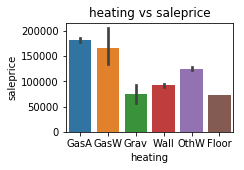

t-test between groups GasA and Grav is significant:  p = 0.0003814245280641231:
t-test between groups GasA and Wall is significant:  p = 0.023469410933238607:
t-test between groups GasW and Grav is significant:  p = 0.006839032791323834:
t-test between groups Grav and OthW is significant:  p = 0.04638313845440468:
t-test between groups Wall and OthW is significant:  p = 0.0011880460057028671:


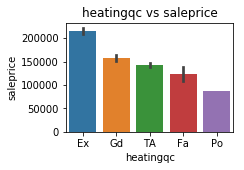

t-test between groups Ex and Gd is significant:  p = 1.8725437000494977e-21:
t-test between groups Ex and TA is significant:  p = 1.5919275272657236e-51:
t-test between groups Ex and Fa is significant:  p = 1.3974031948023897e-12:
t-test between groups Gd and TA is significant:  p = 0.0002858076790877046:
t-test between groups Gd and Fa is significant:  p = 7.931726825148004e-05:
t-test between groups TA and Fa is significant:  p = 0.010412579489135841:


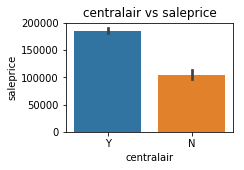

t-test between groups Y and N is significant:  p = 1.8095061559266025e-22:


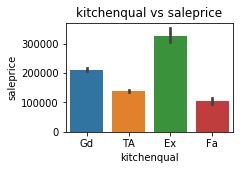

t-test between groups Gd and TA is significant:  p = 3.5567750457395706e-115:
t-test between groups Gd and Ex is significant:  p = 4.814955607123883e-41:
t-test between groups Gd and Fa is significant:  p = 5.241127097982115e-23:
t-test between groups TA and Ex is significant:  p = 8.80410430804081e-147:
t-test between groups TA and Fa is significant:  p = 8.84070711226376e-08:
t-test between groups Ex and Fa is significant:  p = 2.4089805217955344e-21:


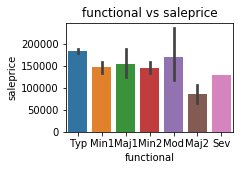

t-test between groups Typ and Min1 is significant:  p = 0.010266696596687372:
t-test between groups Typ and Min2 is significant:  p = 0.004498622087676312:
t-test between groups Typ and Maj2 is significant:  p = 0.00647818115472512:
t-test between groups Min1 and Maj2 is significant:  p = 0.0017325425333195416:
t-test between groups Maj1 and Maj2 is significant:  p = 0.03734796021837928:
t-test between groups Min2 and Maj2 is significant:  p = 0.004151195205877884:


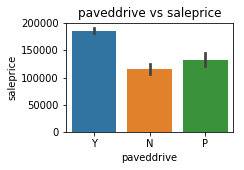

t-test between groups Y and N is significant:  p = 9.573745688949319e-17:
t-test between groups Y and P is significant:  p = 0.00021441163130418177:


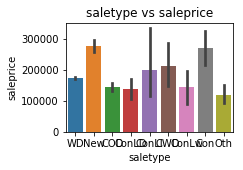

t-test between groups WD and New is significant:  p = 8.105759073532993e-44:
t-test between groups WD and COD is significant:  p = 0.007182281424827325:
t-test between groups New and COD is significant:  p = 1.9747238921367643e-13:
t-test between groups New and ConLD is significant:  p = 0.00014970764055051823:
t-test between groups New and ConLw is significant:  p = 0.0057166345032652:
t-test between groups New and Oth is significant:  p = 0.010751396047659423:
t-test between groups COD and CWD is significant:  p = 0.015543033300174567:
t-test between groups COD and Con is significant:  p = 0.0007760189298330753:
t-test between groups ConLD and Con is significant:  p = 0.016461560587501266:
t-test between groups Con and Oth is significant:  p = 0.04667474868599879:


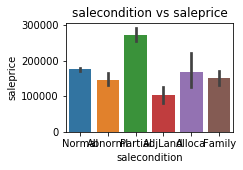

t-test between groups Normal and Abnorml is significant:  p = 9.765967895233726e-05:
t-test between groups Normal and Partial is significant:  p = 7.738631327816656e-42:
t-test between groups Normal and AdjLand is significant:  p = 0.04177743525925718:
t-test between groups Abnorml and Partial is significant:  p = 2.1037526625948678e-19:
t-test between groups Partial and AdjLand is significant:  p = 0.0015829580514197443:
t-test between groups Partial and Alloca is significant:  p = 0.0009025395714440941:
t-test between groups Partial and Family is significant:  p = 7.015548452188403e-07:


In [10]:
#for catgorical variables - get a visual on which variables split house price
#I'm choosing potential categorical variables only on visual inspection, 
#but I would like to do this algorithmically in the future.  

def cat_to_cont(df, cat, cont, threshold):
    """creates a barplot and conducts t-test 
    for a categorical to continuous relationship"""

    #group by
    unique_vals = df[cat].unique()
    grouped_df = df[[cat, cont]].groupby(cat).mean()

    #barplot
    plt.figure(figsize=(3, 2))
    sns.barplot(df[cat], df[cont])
    plt.title("{} vs {}".format(cat, cont))
    plt.show()

    #t-test
    for i in range(0, len(unique_vals)):
        for j in range(i+1, len(unique_vals)):
            t, p = stats.ttest_ind(
                df[df[cat]==unique_vals[i]][cont], 
                df[df[cat]==unique_vals[j]][cont])
            if p < threshold: 
                print("t-test between groups {0} and {1} is significant:  p = {2}:"
                      .format(unique_vals[i], unique_vals[j], p))


for cat in cat_cols: 
    cat_to_cont(houses_df, cat, "saleprice", .05)

In [11]:
#transform the promising categorical variables to one-hot columns and create a features dataframe
neighborhood_df = pd.get_dummies(houses_df.neighborhood, prefix='neighborhood', drop_first=True)
mszoning_df = pd.get_dummies(houses_df.mszoning, prefix='mszoning', drop_first=True)
exterqual_df = pd.get_dummies(houses_df.exterqual, prefix='exterqual', drop_first=True)
kitchenqual_df = pd.get_dummies(houses_df.kitchenqual, prefix='kitchenqual', drop_first=True)
heatingqc_df = pd.get_dummies(houses_df.heatingqc, prefix='heatingqc', drop_first=True)
salecondition_df = pd.get_dummies(houses_df.salecondition, prefix='salecondition', drop_first=True)

features = pd.concat([neighborhood_df, mszoning_df, exterqual_df, 
                      kitchenqual_df, heatingqc_df, salecondition_df], 
                    axis=1)


## An initial model for home prices

Build a simple linear regression model using all of our promising one-hot features (including some highly-correlated features) and estimate it using OLS. 

In [12]:
# Y is the target variable
Y = houses_df['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = features

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

lrm = sm.OLS(Y, X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     75.54
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        11:02:53   Log-Likelihood:                -17674.
No. Observations:                1460   AIC:                         3.544e+04
Df Residuals:                    1416   BIC:                         3.567e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.668e+05   2.19e+04     12.167      0.000    2.24e+05     3.1e+05
neighborhood_Blueste   1.408e+04    3.4e+04      0.414      0.679   -5.27e+04    8.09e+04
neighborhood_BrDale   -1.725e+04   1.72e+04     -1.005      0.315   -5.09e+04    1.64e+04
neighborhood_BrkSide  -6229.7243   1.33e+04     -0.470      0.638   -3.22e+04    1.98e+04
neighborhood_ClearCr   5.614e+04    1.4e+04      4.008      0.000    2.87e+04    8.36e+04
neighborhood_CollgCr   1.873e+04   1.14e+04      1.638      0.102   -3708.322    4.12e+04
neighborhood_Crawfor   5.428e+04   1.28e+04      4.232      0.000    2.91e+04    7.94e+04
neighborhood_Edwards   -1.73e+04   1.22e+04     -1.414      0.158   -4.13e+04    6708.812
neighborhood_Gilbert   2.435e+04   1.21e+04      2.018      0.044     675.178     4.8e+04
neighborhood_IDOTRR   -1.476e+04   1.55e+04     -0.955      0.340   -4.51e+04    1.56e+04
neighborhood_MeadowV  -3.091e+04   1.69e+04     -1.832      0.067    -6.4e+04    2182.181
neighborhood_Mitchel   1.327e+04    1.3e+04      1.018      0.309   -1.23e+04    3.88e+04
neighborhood_NAmes     5308.2068   1.18e+04      0.449      0.654   -1.79e+04    2.85e+04
neighborhood_NPkVill   9846.1700   1.89e+04      0.522      0.602   -2.71e+04    4.68e+04
neighborhood_NWAmes    4.266e+04   1.25e+04      3.409      0.001    1.81e+04    6.72e+04
neighborhood_NoRidge   1.429e+05   1.29e+04     11.058      0.000    1.18e+05    1.68e+05
neighborhood_NridgHt   6.743e+04   1.23e+04      5.499      0.000    4.34e+04    9.15e+04
neighborhood_OldTown  -6150.7275   1.32e+04     -0.467      0.640    -3.2e+04    1.97e+04
neighborhood_SWISU     5359.8208   1.46e+04      0.366      0.714   -2.33e+04    3.41e+04
neighborhood_Sawyer   -1395.2406   1.26e+04     -0.111      0.912   -2.61e+04    2.33e+04
neighborhood_SawyerW   2.145e+04   1.25e+04      1.718      0.086   -3036.113    4.59e+04
neighborhood_Somerst    4.17e+04   1.46e+04      2.860      0.004    1.31e+04    7.03e+04
neighborhood_StoneBr   8.896e+04   1.41e+04      6.308      0.000    6.13e+04    1.17e+05
neighborhood_Timber    5.875e+04   1.31e+04      4.493      0.000    3.31e+04    8.44e+04
neighborhood_Veenker   5.937e+04   1.73e+04      3.423      0.001    2.53e+04    9.34e+04
mszoning_FV            1.029e+04   2.07e+04      0.498      0.618   -3.02e+04    5.08e+04
mszoning_RH            1.872e+04   2.08e+04      0.902      0.367    -2.2e+04    5.94e+04
mszoning_RL            3.212e+04   1.74e+04      1.849      0.065   -1957.146    6.62e+04
mszoning_RM            2.216e+04   1.64e+04      1.349      0.177   -1.01e+04    5.44e+04
exterqual_Fa          -1.039e+05   1.59e+04     -6.540      0.000   -1.35e+05   -7.28e+04
exterqual_Gd           -6.71e+04   7981.249     -8.408      0.000   -8.28e+04   -5.14e+04
exterqual_TA          -

In [13]:
#1. linearity of models in their coefficients - the model chosen de facto satisfies this condition

In [14]:
#2. the error term should be zero on average - and it is very close.  No concerns here. 
#predictions = results.fittedvalues
predictions = results.predict(X)
errors = Y - predictions
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: 8.726364945712155e-10


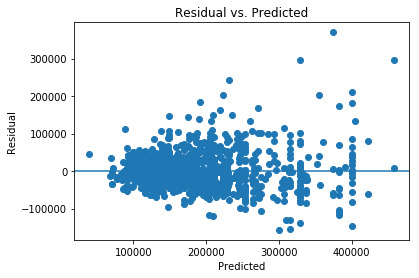

Bartlett test statistic value is 244.419 and p value is 4.28e-55
Levene test statistic value is 181.276 and p value is 3.93e-40


In [15]:
#3. homoscedasticity: the errors are consistently distributed  
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

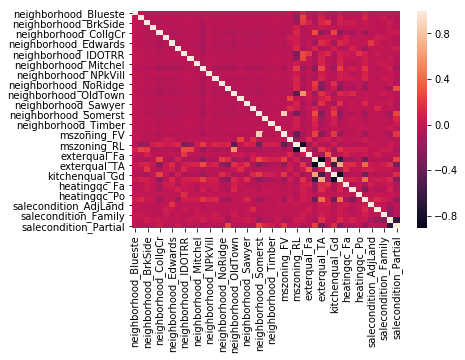

In [16]:
#4. low multicollinearity - THERE ARE A FEW HIGHLY CORRELATED FEATURE PAIRS. 
sns.heatmap(features.corr())
plt.show()

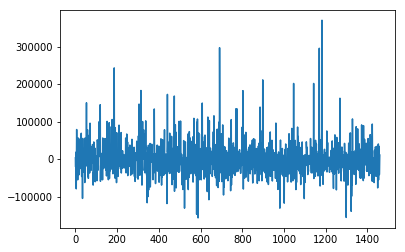

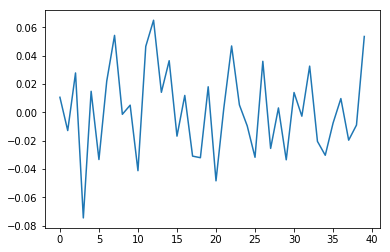

In [17]:
#5. error terms are not correlated with each other. 
plt.plot(errors)
plt.show()

from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

In [18]:
#6. features shouldn't be correlated with the errors - and they aren't

f_err_corrs = [abs(features[feature].corr(errors)) for feature in features.columns]

high_corrs = [(x > 0.1) for x in f_err_corrs]

high_errs_df = pd.DataFrame([features.columns, f_err_corrs]).transpose()[high_corrs]
high_errs_df.columns = ["feature", "correlation with error >0.1"]
high_errs_df

,feature,correlation with error >0.1


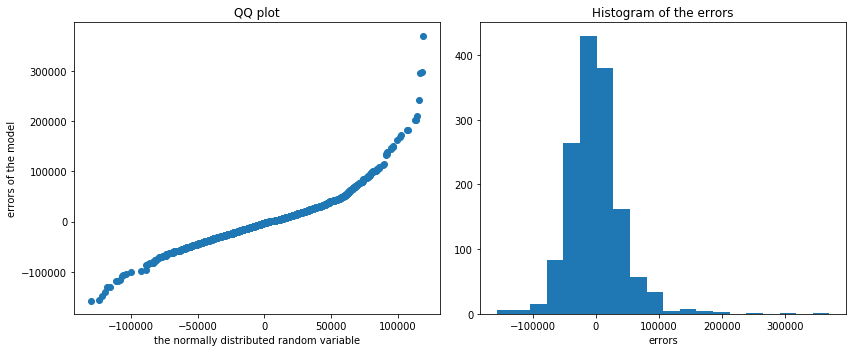

Jarque-Bera test statistics is 5043.63518125381 and p value is 0.0
Normality test statistics is 552.6363431250936 and p value is 9.920711968432696e-121


In [19]:
#7. ERRORS ARE NOT NORMALLY DISTRIBUTED. 

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), errors.sort_values())
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors, bins = 20)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

We've found 2 concerns:  

* There are a few highly correlated feature pairs. 
* The errors are not normally distribured

To mitigate both concerns, let's create a second feature set that (a) removes the least powerful feature in each highly correlated pair and (b) adds some more features.  

In [20]:
#find some powerful continuous variables

print(type(features))

#take the 5 with the highest correlation with sales price 
cont_corrs = np.abs(houses_df[cont_cols].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)
top_cont = cont_corrs.head(10)[1:6].index.values

#add the new columns to the features dataframe
for cont in top_cont: 
    features[cont] = houses_df[cont]

print(features.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['neighborhood_Blueste', 'neighborhood_BrDale', 'neighborhood_BrkSide',
       'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor',
       'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR',
       'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes',
       'neighborhood_NPkVill', 'neighborhood_NWAmes', 'neighborhood_NoRidge',
       'neighborhood_NridgHt', 'neighborhood_OldTown', 'neighborhood_SWISU',
       'neighborhood_Sawyer', 'neighborhood_SawyerW', 'neighborhood_Somerst',
       'neighborhood_StoneBr', 'neighborhood_Timber', 'neighborhood_Veenker',
       'mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM',
       'exterqual_Fa', 'exterqual_Gd', 'exterqual_TA', 'kitchenqual_Fa',
       'kitchenqual_Gd', 'kitchenqual_TA', 'heatingqc_Fa', 'heatingqc_Gd',
       'heatingqc_Po', 'heatingqc_TA', 'salecondition_AdjLand',
       'salecondition_Alloca', 'salecondition_Family', 'sale

In [21]:
#find highly correlated feature pairs and remove the one with lowest correlation with sales price
#note I'm pretty sure the pd.DataFrame.corr will work with a catagorical / continuous comparison...
#but I need to confirm it's working as I expect. 

keywords = features.columns
target_corr = {key: abs(houses_df["saleprice"].corr(features[key])) for key in keywords}

correlations = []

for key in keywords: 
    for key2 in keywords: 
        correlations.append((key, key2, abs(features[key].corr(features[key2]))))

correlations = pd.DataFrame(correlations)
correlations.columns = ["key", "key2", "corr"]
correlations = correlations.sort_values(by="corr", ascending=False)
correlations["key_target_corr"] = float(0)
correlations["key2_target_corr"] = float(0)
correlations["key2_better"] = False

for i , row in correlations.iterrows():
    correlations.at[i,'key_target_corr'] = target_corr.get(correlations.at[i, "key"])
    correlations.at[i, "key2_target_corr"] = target_corr.get(correlations.at[i, "key2"])
    correlations.at[i, "key2_better"] = correlations.at[i, "key_target_corr"] < correlations.at[i, "key2_target_corr"]

#find all the rows where the keys are the same and drop them from the correlations table
correlations = correlations[correlations.key != correlations.key2]

keys_to_drop = set()

#find all the rows where the corr is greater than a threshold and id the less powerful key to drop
keys_to_drop.update(set(correlations.loc[(correlations["corr"] > .5) & 
                                         (correlations["key2_better"]==True), "key" ].values))

#find all the rows where the corr is equal and the target correlations are equivalent
#if neither of these is already in the list to drop, drop one of them
exact_matches = correlations.loc[(correlations["corr"] == 1.0) &  
                                     (correlations.key_target_corr == correlations.key2_target_corr),
                                     ["key", "key2"]].values
for match in exact_matches:
    if (not (match[0] in keys_to_drop or match[1] in keys_to_drop)): 
        keys_to_drop.add(match[0])

keywords = set(keywords) - set(keys_to_drop)

features2 = features.drop(keys_to_drop, axis=1)
print("dropped features:", keys_to_drop)
print("reduced features list:",  features2.columns)


dropped features: {'mszoning_FV', 'grlivarea', 'salecondition_Normal', 'exterqual_Gd', 'kitchenqual_Gd', 'garagecars', 'exterqual_TA', 'kitchenqual_TA', 'mszoning_RL', 'garagearea', 'neighborhood_OldTown', 'totalbsmtsf'}
reduced features list: Index(['neighborhood_Blueste', 'neighborhood_BrDale', 'neighborhood_BrkSide',
       'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor',
       'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR',
       'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NAmes',
       'neighborhood_NPkVill', 'neighborhood_NWAmes', 'neighborhood_NoRidge',
       'neighborhood_NridgHt', 'neighborhood_SWISU', 'neighborhood_Sawyer',
       'neighborhood_SawyerW', 'neighborhood_Somerst', 'neighborhood_StoneBr',
       'neighborhood_Timber', 'neighborhood_Veenker', 'mszoning_RH',
       'mszoning_RM', 'exterqual_Fa', 'kitchenqual_Fa', 'heatingqc_Fa',
       'heatingqc_Gd', 'heatingqc_Po', 'heatingqc_TA', 'salecondition_

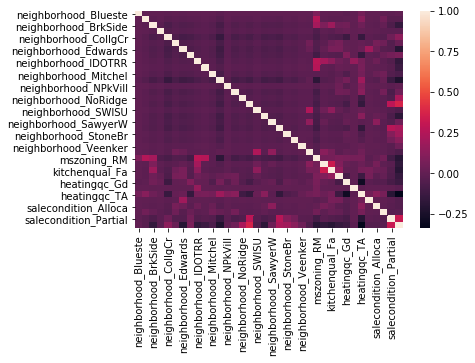

In [22]:
#the new correlation heatmap looks pretty good
sns.heatmap(features2.corr())
plt.show()

## A model with the reduced features set

Let's build a new model with the new feature set.  

In [23]:
# Y is the target variable
Y = houses_df['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = features2

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     106.0
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        11:02:57   Log-Likelihood:                -17592.
No. Observations:                1460   AIC:                         3.526e+04
Df Residuals:                    1423   BIC:                         3.545e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.904e+04   8776.422     -3.309      0.001   -4.63e+04   -1.18e+04
neighborhood_Blueste  -2673.4780      3e+04     -0.089      0.929   -6.15e+04    5.61e+04
neighborhood_BrDale   -2.568e+04   1.13e+04     -2.273      0.023   -4.78e+04   -3521.905
neighborhood_BrkSide   5882.9789   6804.575      0.865      0.387   -7465.096    1.92e+04
neighborhood_ClearCr   5.622e+04   9488.454      5.925      0.000    3.76e+04    7.48e+04
neighborhood_CollgCr   1.177e+04   6228.030      1.890      0.059    -446.518     2.4e+04
neighborhood_Crawfor   4.404e+04   7809.929      5.639      0.000    2.87e+04    5.94e+04
neighborhood_Edwards    165.1731   6548.128      0.025      0.980   -1.27e+04     1.3e+04
neighborhood_Gilbert   9461.2735   7131.162      1.327      0.185   -4527.445    2.34e+04
neighborhood_IDOTRR   -6354.6662   8097.178     -0.785      0.433   -2.22e+04    9529.021
neighborhood_MeadowV   6222.1600    1.1e+04      0.565      0.572   -1.54e+04    2.78e+04
neighborhood_Mitchel   1.091e+04   7748.286      1.408      0.159   -4286.197    2.61e+04
neighborhood_NAmes     9789.2364   5942.225      1.647      0.100   -1867.224    2.14e+04
neighborhood_NPkVill  -1.167e+04   1.51e+04     -0.775      0.439   -4.12e+04    1.79e+04
neighborhood_NWAmes    2.256e+04   7286.256      3.097      0.002    8269.438    3.69e+04
neighborhood_NoRidge   1.096e+05   8840.065     12.399      0.000    9.23e+04    1.27e+05
neighborhood_NridgHt   6.741e+04   7772.216      8.673      0.000    5.22e+04    8.27e+04
neighborhood_SWISU     4649.1226   1.02e+04      0.457      0.648   -1.53e+04    2.46e+04
neighborhood_Sawyer      1.1e+04   7118.944      1.545      0.123   -2964.461     2.5e+04
neighborhood_SawyerW   1.545e+04   7703.915      2.005      0.045     334.964    3.06e+04
neighborhood_Somerst   7396.3066   7298.955      1.013      0.311   -6921.560    2.17e+04
neighborhood_StoneBr   6.985e+04   1.03e+04      6.771      0.000    4.96e+04    9.01e+04
neighborhood_Timber    3.847e+04   8752.431      4.395      0.000    2.13e+04    5.56e+04
neighborhood_Veenker   5.535e+04   1.38e+04      4.025      0.000    2.84e+04    8.23e+04
mszoning_RH           -1.608e+04   1.12e+04     -1.442      0.150    -3.8e+04    5801.852
mszoning_RM           -1.463e+04   4932.864     -2.966      0.003   -2.43e+04   -4956.650
exterqual_Fa           1.226e+04   1.24e+04      0.989      0.323   -1.21e+04    3.66e+04
kitchenqual_Fa        -4369.4108   7584.468     -0.576      0.565   -1.92e+04    1.05e+04
heatingqc_Fa          -1.348e+04   6596.538     -2.044      0.041   -2.64e+04    -541.009
heatingqc_Gd          -9352.6396   3391.203     -2.758      0.006    -1.6e+04   -2700.346
heatingqc_Po          -2.408e+04   4.26e+04     -0.565      0.572   -1.08e+05    5.95e+04
heatingqc_TA          -

This both reduced the multi-colinearity problem and improved the predictive power of the model (from R=.70 to R=.73).   

Let's see if it improved the normality of the errors. 

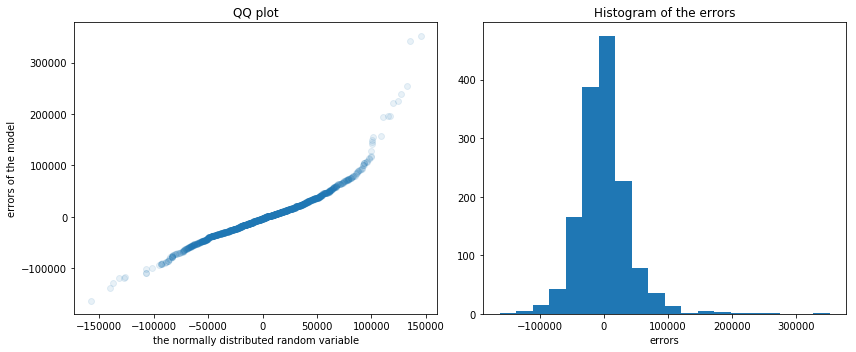

Jarque-Bera test statistics is 7427.754287093701 and p value is 0.0
Normality test statistics is 621.4948041627138 and p value is 1.1069245263308023e-135


In [24]:
#7. ERRORS ARE NOT NORMALLY DISTRIBUTED. 

predictions = results.predict(X)
errors = Y - predictions

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), errors.sort_values(), alpha = 0.1)
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors, bins = 20)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Still not normal per the Jarque-Bera and Normality tests.   

What do the high error rows look like?  

In [25]:
#get the index values where the errors are > 150000

err_df = pd.DataFrame(errors)
err_df.columns = ["error"]
outlier_indices = list(err_df[err_df.error > 150000].index.values)
houses_df.iloc[outlier_indices, :]

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
186,186,75,RM,22950,Pave,IR2,Lvl,AllPub,Inside,Gtl,...,0,0,410,0,0,6,2006,WD,Normal,475000
441,441,20,RL,15431,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,170,0,0,4,2009,WD,Normal,555000
664,665,20,RL,20896,Pave,IR2,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,1,2006,New,Partial,423000
691,692,60,RL,21535,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2007,WD,Normal,755000
769,770,60,RL,53504,Pave,IR2,HLS,AllPub,CulDSac,Mod,...,0,0,210,0,0,6,2010,WD,Normal,538000
803,804,60,RL,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,192,0,0,1,2009,New,Partial,582933
898,899,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2010,New,Partial,611657
1046,1047,60,RL,16056,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2006,New,Partial,556581
1142,1143,60,RL,9965,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2007,New,Partial,424870
1169,1170,60,RL,35760,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,625000


In [26]:
houses_df[houses_df.saleprice > 530000]

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
441,441,20,RL,15431,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,170,0,0,4,2009,WD,Normal,555000
691,692,60,RL,21535,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2007,WD,Normal,755000
769,770,60,RL,53504,Pave,IR2,HLS,AllPub,CulDSac,Mod,...,0,0,210,0,0,6,2010,WD,Normal,538000
803,804,60,RL,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,192,0,0,1,2009,New,Partial,582933
898,899,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2010,New,Partial,611657
1046,1047,60,RL,16056,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,7,2006,New,Partial,556581
1169,1170,60,RL,35760,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,0,0,0,0,7,2006,WD,Normal,625000
1182,1183,60,RL,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,555,0,7,2007,WD,Abnorml,745000


It turns out they are very similar.  Most notably the 11 outliers include the 8 most expensive houses in the dataset.  If we removed those from the dataset and re-built the model, what would the normality test look like? 

In [27]:
purged_index = list(houses_df.loc[houses_df.saleprice < 530000].index.values)

# Y is the target variable
Y = houses_df.loc[purged_index, 'saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = features2.loc[purged_index, :]

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     116.4
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        11:02:58   Log-Likelihood:                -17307.
No. Observations:                1452   AIC:                         3.469e+04
Df Residuals:                    1415   BIC:                         3.488e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.658e+04   7740.358     -2.141      0.032   -3.18e+04   -1391.266
neighborhood_Blueste  -1640.8983   2.63e+04     -0.062      0.950   -5.33e+04       5e+04
neighborhood_BrDale   -2.549e+04   9919.961     -2.570      0.010    -4.5e+04   -6033.075
neighborhood_BrkSide   4915.7475   5975.964      0.823      0.411   -6806.953    1.66e+04
neighborhood_ClearCr   5.693e+04   8332.844      6.832      0.000    4.06e+04    7.33e+04
neighborhood_CollgCr    1.41e+04   5470.726      2.577      0.010    3365.452    2.48e+04
neighborhood_Crawfor   4.572e+04   6859.428      6.666      0.000    3.23e+04    5.92e+04
neighborhood_Edwards   -736.7479   5750.753     -0.128      0.898    -1.2e+04    1.05e+04
neighborhood_Gilbert   1.158e+04   6263.526      1.849      0.065    -705.582    2.39e+04
neighborhood_IDOTRR   -7732.3740   7111.261     -1.087      0.277   -2.17e+04    6217.374
neighborhood_MeadowV   3667.5488   9672.886      0.379      0.705   -1.53e+04    2.26e+04
neighborhood_Mitchel   1.099e+04   6804.551      1.615      0.107   -2362.019    2.43e+04
neighborhood_NAmes     9411.1242   5218.562      1.803      0.072    -825.827    1.96e+04
neighborhood_NPkVill  -1.026e+04   1.32e+04     -0.776      0.438   -3.62e+04    1.57e+04
neighborhood_NWAmes    2.434e+04   6399.878      3.803      0.000    1.18e+04    3.69e+04
neighborhood_NoRidge   8.995e+04   7887.213     11.405      0.000    7.45e+04    1.05e+05
neighborhood_NridgHt   6.462e+04   6863.990      9.414      0.000    5.12e+04    7.81e+04
neighborhood_SWISU     4851.9212   8940.825      0.543      0.587   -1.27e+04    2.24e+04
neighborhood_Sawyer    9892.3600   6252.126      1.582      0.114   -2372.073    2.22e+04
neighborhood_SawyerW    1.71e+04   6766.334      2.527      0.012    3823.104    3.04e+04
neighborhood_Somerst   1.174e+04   6414.391      1.831      0.067    -838.388    2.43e+04
neighborhood_StoneBr   5.685e+04   9310.003      6.106      0.000    3.86e+04    7.51e+04
neighborhood_Timber    4.212e+04   7688.757      5.478      0.000     2.7e+04    5.72e+04
neighborhood_Veenker   5.781e+04   1.21e+04      4.787      0.000    3.41e+04    8.15e+04
mszoning_RH           -1.696e+04   9798.244     -1.731      0.084   -3.62e+04    2263.651
mszoning_RM           -1.432e+04   4332.111     -3.306      0.001   -2.28e+04   -5822.078
exterqual_Fa           9920.8190   1.09e+04      0.911      0.362   -1.14e+04    3.13e+04
kitchenqual_Fa        -5524.9830   6660.918     -0.829      0.407   -1.86e+04    7541.353
heatingqc_Fa          -1.476e+04   5793.765     -2.547      0.011   -2.61e+04   -3390.535
heatingqc_Gd          -9183.1763   2979.167     -3.082      0.002    -1.5e+04   -3339.117
heatingqc_Po          -2.456e+04   3.74e+04     -0.657      0.512   -9.79e+04    4.88e+04
heatingqc_TA          -

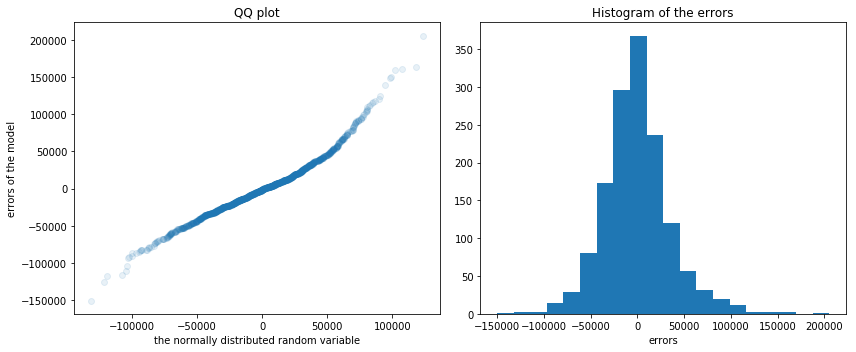

Jarque-Bera test statistics is 477.78620070185616 and p value is 0.0
Normality test statistics is 174.32922957218733 and p value is 1.3960108097443464e-38


In [28]:
#running error normality test
predictions = results.predict(X)
errors = Y - predictions

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), errors.sort_values(), alpha = 0.1)
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors, bins = 20)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

### Coefficient Interpretation

**Which features are statistically significant, and which are not?**
(see list below)

**Now, exclude the insignificant features from your model. Did anything change?**
Rsquared improved to .84 from .75
Several more features have become insignificant. 

**Interpret the statistically significant coefficients by quantifying their relations with the house prices. Which features have a more prominent effect on house prices?**
See below for a listing of statistically significant independent variables by coefficient size. 

**Do the results sound reasonable to you? If not, try to explain the potential reasons.**
It's intuitively appealing that price is most impacted by posh neighborhoods, school zones, type of sale (e.g. foreclosure I assume),and curb appeal (external quality).  Nothing suprising here. 

In [29]:
#dropping programmatically the features that are insignificant from the features set: 

insign_features = list(results.pvalues[results.pvalues > 0.1].index.values)
features3 = features.drop(insign_features, axis=1)

In [30]:

print(insign_features)
features3.head()

['neighborhood_Blueste', 'neighborhood_BrkSide', 'neighborhood_Edwards', 'neighborhood_IDOTRR', 'neighborhood_MeadowV', 'neighborhood_Mitchel', 'neighborhood_NPkVill', 'neighborhood_SWISU', 'neighborhood_Sawyer', 'exterqual_Fa', 'kitchenqual_Fa', 'heatingqc_Po', 'salecondition_AdjLand', 'salecondition_Family']


,neighborhood_BrDale,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Gilbert,neighborhood_NAmes,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,...,heatingqc_Gd,heatingqc_TA,salecondition_Alloca,salecondition_Normal,salecondition_Partial,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,7,1710,2,548,856
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,6,1262,2,460,1262
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,7,1786,2,608,920
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,7,1717,3,642,756
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,8,2198,3,836,1145


In [31]:
# Y is the target variable
Y = houses_df.loc[purged_index, 'saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = features3.loc[purged_index, :]

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     212.0
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        11:02:59   Log-Likelihood:                -16996.
No. Observations:                1452   AIC:                         3.406e+04
Df Residuals:                    1417   BIC:                         3.425e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.965e+04   1.13e+04     -2.613      0.009   -5.19e+04   -7390.207
neighborhood_BrDale   -7489.4887   8020.038     -0.934      0.351   -2.32e+04    8242.935
neighborhood_ClearCr   3.574e+04   5948.466      6.009      0.000    2.41e+04    4.74e+04
neighborhood_CollgCr   1.283e+04   3407.418      3.767      0.000    6150.732    1.95e+04
neighborhood_Crawfor   3.404e+04   4610.951      7.383      0.000     2.5e+04    4.31e+04
neighborhood_Gilbert   1.013e+04   4155.327      2.437      0.015    1974.916    1.83e+04
neighborhood_NAmes     4624.9290   2656.807      1.741      0.082    -586.769    9836.627
neighborhood_NWAmes    9339.5120   4087.313      2.285      0.022    1321.678    1.74e+04
neighborhood_NoRidge    5.83e+04   5816.018     10.023      0.000    4.69e+04    6.97e+04
neighborhood_NridgHt    4.69e+04   4879.368      9.612      0.000    3.73e+04    5.65e+04
neighborhood_OldTown  -7536.8326   3718.935     -2.027      0.043   -1.48e+04    -241.623
neighborhood_SawyerW   1.118e+04   4510.334      2.479      0.013    2333.233       2e+04
neighborhood_Somerst   2.122e+04   7332.642      2.894      0.004    6834.890    3.56e+04
neighborhood_StoneBr   5.316e+04   6985.105      7.611      0.000    3.95e+04    6.69e+04
neighborhood_Timber    3.021e+04   5438.130      5.556      0.000    1.95e+04    4.09e+04
neighborhood_Veenker   4.863e+04   9291.409      5.234      0.000    3.04e+04    6.69e+04
mszoning_FV            2.867e+04   1.24e+04      2.311      0.021    4332.513     5.3e+04
mszoning_RH            1.982e+04   1.23e+04      1.617      0.106   -4228.699    4.39e+04
mszoning_RL            3.665e+04   9862.957      3.716      0.000    1.73e+04     5.6e+04
mszoning_RM             2.66e+04   1.01e+04      2.646      0.008    6877.142    4.63e+04
exterqual_Gd          -1.904e+04   4783.656     -3.981      0.000   -2.84e+04   -9658.844
exterqual_TA           -1.89e+04   5022.872     -3.762      0.000   -2.88e+04   -9044.758
kitchenqual_Gd        -1.381e+04   3376.823     -4.089      0.000   -2.04e+04   -7182.294
kitchenqual_TA        -1.852e+04   3480.410     -5.321      0.000   -2.53e+04   -1.17e+04
heatingqc_Fa          -1.426e+04   4660.525     -3.059      0.002   -2.34e+04   -5114.414
heatingqc_Gd          -6073.7233   2436.988     -2.492      0.013   -1.09e+04   -1293.231
heatingqc_TA          -7645.4598   2269.770     -3.368      0.001   -1.21e+04   -3192.990
salecondition_Alloca   1.403e+04   9267.845      1.514      0.130   -4145.924    3.22e+04
salecondition_Normal   1.146e+04   2883.976      3.974      0.000    5802.174    1.71e+04
salecondition_Partial  2.499e+04   4263.358      5.862      0.000    1.66e+04    3.34e+04
overallqual            1.451e+04   1018.462     14.251      0.000    1.25e+04    1.65e+04
grlivarea              

In [32]:
#listing of independent variables by coefficient size
results.params[results.pvalues < 0.1].sort_values()

const                   -29645.283590
exterqual_Gd            -19042.652956
exterqual_TA            -18897.821462
kitchenqual_TA          -18519.107114
heatingqc_Fa            -14256.683638
kitchenqual_Gd          -13806.403983
heatingqc_TA             -7645.459830
neighborhood_OldTown     -7536.832567
heatingqc_Gd             -6073.723273
garagearea                  14.455228
totalbsmtsf                 17.176554
grlivarea                   36.399894
neighborhood_NAmes        4624.928965
neighborhood_NWAmes       9339.512028
neighborhood_Gilbert     10126.170700
garagecars               10872.281204
neighborhood_SawyerW     11180.882490
salecondition_Normal     11459.495265
neighborhood_CollgCr     12834.856597
overallqual              14513.743092
neighborhood_Somerst     21218.889835
salecondition_Partial    24990.269741
mszoning_RM              26603.058118
mszoning_FV              28666.453199
neighborhood_Timber      30212.433550
neighborhood_Crawfor     34040.829563
neighborhood

**Assess the goodness of fit of your model using F-test, R-squared, adjusted R-squared, AIC and BIC.
Do you think your model is satisfactory? If so, why?**

The model performance is strong: 
* The p-value for the F-stastic is very close to 0, indicating we can reject the hypothesis that the model does not explain the target variable's variance. 
* R-squared and Adjusted R-squared indicate the model explains ~83-84% of the variance, which is pretty good 
* AIC and BIC are both extremely high (e+04)

**In order to improve the goodness of fit of your model, try different model specifications by adding or removing some variables. For each model you try, get the goodness of fit metrics and compare your models with each other. Which model is the best and why?

Below, I've removed the variables that are not significant in the last model developed above.  A comparison (see table below, shows little change in the r-squared, adjusted r-squared, AIC or BIC metrics.  They are all very slightly worse as compared to the model that includes the insignificant variables.  I would choose to move forward with the new model, preferring the reduced number of variables. 

The resulting model has another variable whose coefficient became insignificant.  Removing it also creates no meaningful change in the performance metrics.  

This simplification process - removing the least significant variables - could be continued iteratively until too much power has been removed from the model.  

In [45]:
# create the new model and compare with the prior model...

sign_cols = results.params[results.pvalues < 0.1].index.values[1:]

Y = houses_df.loc[purged_index, 'saleprice']
X = features3.loc[purged_index, sign_cols]
X = sm.add_constant(X)
results2 = sm.OLS(Y, X).fit()

#collect R2, AdjR2, AIC and BIC for the models

AICs = [results.aic, results2.aic]
BICs = [results.bic, results2.bic]
R2s = [results.rsquared, results2.rsquared]
R2Adjs = [results.rsquared_adj, results2.rsquared_adj]

summ_results = pd.DataFrame({"AICs": AICs, "BICs": BICs, "R2s": R2s, "R2Adjs": R2Adjs})
summ_results.index = ["with_insig", "without_insig"]
summ_results

,AICs,BICs,R2s,R2Adjs
with_insig,34061.567857,34246.392258,0.835691,0.831749
without_insig,34061.305807,34230.288117,0.835041,0.831439


In [59]:
#not shows - but the new model has another insignficant coefficent (garagearea).  removing that and summarizing again

sign_cols = results2.params[results2.pvalues < 0.1].index.values[1:]

Y = houses_df.loc[purged_index, 'saleprice']
X = features3.loc[purged_index, sign_cols]
X = sm.add_constant(X)
results3 = sm.OLS(Y, X).fit()

#collect R2, AdjR2, AIC and BIC for the models

def compare_model_results(results): 
    AICs = []
    BICs = []
    R2s = []
    R2Adjs = []
    model_names = []
    i = 1
    
    for result in results: 
        AICs.append(result.aic)
        BICs.append(result.bic)
        R2s.append(result.rsquared)
        R2Adjs.append(result.rsquared_adj)
        model_names.append("model {}".format(i))
        i += 1
    
    summary = pd.DataFrame({"AICs": AICs, "BICs": BICs, "R2s": R2s, "R2Adjs": R2Adjs})
    summary.index = model_names
    return summary

compare_model_results([results, results2, results3])

,AICs,BICs,R2s,R2Adjs
model 1,34061.567857,34246.392258,0.835691,0.831749
model 2,34061.305807,34230.288117,0.835041,0.831439
model 3,34061.774708,34225.476321,0.834760,0.831271


In [60]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     239.3
Date:                Wed, 29 May 2019   Prob (F-statistic):               0.00
Time:                        11:32:42   Log-Likelihood:                -17000.
No. Observations:                1452   AIC:                         3.406e+04
Df Residuals:                    1421   BIC:                         3.423e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -1.7e+04   9109.284     -1.866      0.062   -3.49e+04     872.819
neighborhood_ClearCr    3.56e+04   5953.784      5.979      0.000    2.39e+04    4.73e+04
neighborhood_CollgCr   1.363e+04   3396.714      4.013      0.000    6968.469    2.03e+04
neighborhood_Crawfor   3.451e+04   4595.634      7.508      0.000    2.55e+04    4.35e+04
neighborhood_Gilbert   9194.5688   4109.383      2.237      0.025    1133.460    1.73e+04
neighborhood_NAmes     5035.2914   2645.910      1.903      0.057    -155.017    1.02e+04
neighborhood_NWAmes    9270.8941   4084.150      2.270      0.023    1259.284    1.73e+04
neighborhood_NoRidge   5.847e+04   5821.484     10.044      0.000    4.71e+04    6.99e+04
neighborhood_NridgHt   4.772e+04   4872.215      9.794      0.000    3.82e+04    5.73e+04
neighborhood_OldTown  -6795.7264   3633.556     -1.870      0.062   -1.39e+04     331.983
neighborhood_SawyerW   1.281e+04   4450.116      2.878      0.004    4076.297    2.15e+04
neighborhood_Somerst   2.231e+04   7325.224      3.045      0.002    7938.152    3.67e+04
neighborhood_StoneBr   5.341e+04   6993.706      7.637      0.000    3.97e+04    6.71e+04
neighborhood_Timber    3.033e+04   5443.430      5.572      0.000    1.97e+04     4.1e+04
neighborhood_Veenker   4.882e+04   9303.426      5.248      0.000    3.06e+04    6.71e+04
mszoning_FV             1.58e+04   9731.269      1.624      0.105   -3288.896    3.49e+04
mszoning_RL            2.397e+04   6181.188      3.878      0.000    1.18e+04    3.61e+04
mszoning_RM            1.308e+04   6570.090      1.992      0.047     196.503     2.6e+04
exterqual_Gd          -1.925e+04   4773.468     -4.033      0.000   -2.86e+04   -9888.015
exterqual_TA          -1.885e+04   5004.471     -3.767      0.000   -2.87e+04   -9032.477
kitchenqual_Gd        -1.394e+04   3380.382     -4.123      0.000   -2.06e+04   -7306.651
kitchenqual_TA        -1.848e+04   3481.955     -5.307      0.000   -2.53e+04   -1.16e+04
heatingqc_Fa          -1.456e+04   4662.765     -3.122      0.002   -2.37e+04   -5410.125
heatingqc_Gd          -6136.1391   2439.082     -2.516      0.012   -1.09e+04   -1351.552
heatingqc_TA          -7444.0821   2253.157     -3.304      0.001   -1.19e+04   -3024.210
salecondition_Normal   1.089e+04   2765.156      3.937      0.000    5461.289    1.63e+04
salecondition_Partial  2.468e+04   4186.596      5.896      0.000    1.65e+04    3.29e+04
overallqual            1.442e+04   1010.474     14.272      0.000    1.24e+04    1.64e+04
grlivarea                37.1152      2.094     17.727      0.000      33.008      41.222
garagecars             1.432e+04   1412.379     10.142      0.000    1.16e+04    1.71e+04
totalbsmtsf              17.7428      2.365      7.501      0.000      13.103      22.383
=======================